## Pose embedding visualization

This notebook visualizes differences in pose embeddings. It uses two forms of embeddings: Angle-based embeddings between keypoints and google reasearch poem embeddings. 

In [145]:
from emv.db.dao import DataAccessObject
from sqlalchemy.sql import text
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast
import matplotlib.gridspec as gridspec
import psycopg2s
import pandas as pd

In [5]:
keypoint_names = ['nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
                  'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee',
                  'right_knee', 'left_ankle', 'right_ankle']

connections = [
    ('nose', 'left_shoulder'), ('nose', 'right_shoulder'),
    ('left_shoulder', 'left_elbow'), ('left_elbow', 'left_wrist'),
    ('right_shoulder', 'right_elbow'), ('right_elbow', 'right_wrist'),
    ('left_shoulder', 'left_hip'), ('right_shoulder', 'right_hip'),
    ('left_hip', 'left_knee'), ('left_knee', 'left_ankle'),
    ('right_hip', 'right_knee'), ('right_knee', 'right_ankle'),
    ('left_hip', 'right_hip')
]

In [48]:
def plot_pose(keypoints, keypoint_names, connections, filename):
    plt.figure(figsize=(2, 2))
    keypoint_dict = {name: keypoints[i] for i, name in enumerate(keypoint_names)}
    
    # Extract all y-values to find the maximum y for flipping
    y_values = [kp[1] for kp in keypoints if kp[2] > 0]
    max_y = max(y_values)
    
    for connection in connections:
        kp1 = keypoint_dict[connection[0]]
        kp2 = keypoint_dict[connection[1]]
        
        # Check if keypoints are detected with sufficient confidence
        if kp1[2] > 0 and kp2[2] > 0:
            x_values = [kp1[0], kp2[0]]
            # Flip the y-values
            y_values = [max_y - kp1[1], max_y - kp2[1]]
            plt.plot(x_values, y_values, 'k-', lw=2)
    
    for kp in keypoints:
        if kp[2] > 0:
            plt.plot(kp[0], max_y - kp[1], 'ro', markersize=4)
    
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()


In [65]:
query = text("""SELECT data->'keypoints' as keypoints, embedding_33  FROM feature WHERE feature_type = 'pose_image' LIMIT 10""") 
poses = [x['keypoints'] for x in DataAccessObject().fetch_all(query)]
embeddings = [ast.literal_eval(x['embedding_33']) for x in DataAccessObject().fetch_all(query)]

In [70]:
src_embedding = [0.4137573, 0.12165371, 0.464589, 0.50230044, 0.15348649, 0.34421307, 0.2865249, 0.13849163, 0.5749835, 0.5967613, 0.1807144, 0.2225243, 0.14689337, 0.15396494, 0.6991417, 0.78802323, 0.11799447, 0.0939823, 0.01782008, 0.10402318, 0.8781567, 0.54591733, 0.18397652, 0.27010617, 0.25353327, 0.180394, 0.5660727, 0.54073083, 0.10695903, 0.35231015, 0.34235886, 0.10900193, 0.54863924]

In [95]:
query = text("""
    SELECT 
        feature.media_id, 
        feature.feature_id,
        :angle_feature <-> feature.embedding_33 AS distance
    FROM feature
    WHERE feature_type = :feature_type 
    ORDER BY distance DESC
    LIMIT :k;"""
)

result = DataAccessObject().fetch_all(
    query, {
        "angle_feature": psycopg2.extras.Json(src_embedding),  # Pass the formatted array
        "feature_type": "pose_image",
        "k": 100000
    }
)

In [100]:
# sample 10 from the result list
random_nums = np.random.randint(0, len(result), 10)
sample = [result[i] for i in random_nums]

In [110]:
query_results = []

for s in sample:
    query = text("""SELECT data->'keypoints' as keypoints, embedding_33 FROM feature WHERE feature_id = :feature_id""")
    query_results.append(DataAccessObject().fetch_one(query, {"feature_id": s['feature_id']}))

poses = [x['keypoints'] for x in query_results]
embeddings = [ast.literal_eval(x['embedding_33']) for x in query_results]

In [135]:
def retrieve_samples(src_embedding):
    # Do a sort of grid over all the database embeddings. The goal is that they are varied enough so we can compare different embedding strategies
    # Returns keypoints and embeddings for each of the samples
    query_all = text("""
        SELECT 
            feature.media_id, 
            feature.feature_id,
            :angle_feature <-> feature.embedding_33 AS distance
        FROM feature
        WHERE feature_type = :feature_type 
        ORDER BY distance DESC
        LIMIT :k;"""
    )

    result = DataAccessObject().fetch_all(
        query_all, {
            "angle_feature": psycopg2.extras.Json(src_embedding),  # Pass the formatted array
            "feature_type": "pose_image",
            "k": 100000
        }
    )

    # sample 10 from the result list
    random_nums = np.random.randint(0, len(result), 10)
    sample = [result[i] for i in random_nums]

    query_results = []

    for s in sample:
        query = text("""SELECT data->'keypoints' as keypoints, embedding_33 FROM feature WHERE feature_id = :feature_id""")
        query_results.append(DataAccessObject().fetch_one(query, {"feature_id": s['feature_id']}))

    poses = [x['keypoints'] for x in query_results]
    embeddings = [ast.literal_eval(x['embedding_33']) for x in query_results]

    # for each of the results, repeat the process
    all_keypoints = []
    all_embeddings = []
    all_feature_ids = []

    for i, emb in enumerate(embeddings):
        result = DataAccessObject().fetch_all(
            query_all, {
                "angle_feature": psycopg2.extras.Json(emb),  # Pass the formatted array
                "feature_type": "pose_image",
                "k": 100000
            }
        )

        # sample 10 from the result list
        random_nums = np.random.randint(0, len(result), 10)
        sample = [result[i] for i in random_nums]

        query_results = []

        for s in sample:
            query = text("""SELECT data->'keypoints' as keypoints, embedding_33, feature_id FROM feature WHERE feature_id = :feature_id""")
            query_results.append(DataAccessObject().fetch_one(query, {"feature_id": s['feature_id']}))

        poses = [x['keypoints'] for x in query_results]
        embeddings = [ast.literal_eval(x['embedding_33']) for x in query_results]

        all_feature_ids.extend([x['feature_id'] for x in query_results])
        all_keypoints.extend(poses)
        all_embeddings.extend(embeddings)
    
    return all_keypoints, all_embeddings, all_feature_ids


In [198]:
poses, embeddings, feature_ids = retrieve_samples(src_embedding)

In [199]:
poses_1 = poses[:30]
embeddings_1 = embeddings[:30]

In [200]:
with open("feature_ids.txt", "w") as f:
    for item in feature_ids:
        f.write("%s\n" % item)

In [201]:
def compute_similarity(pose1, pose2):
    embeddings_0 = np.array(pose1).reshape(1, -1)
    embeddings_1 = np.array(pose2).reshape(1, -1)
    return cosine_similarity(embeddings_0, embeddings_1)

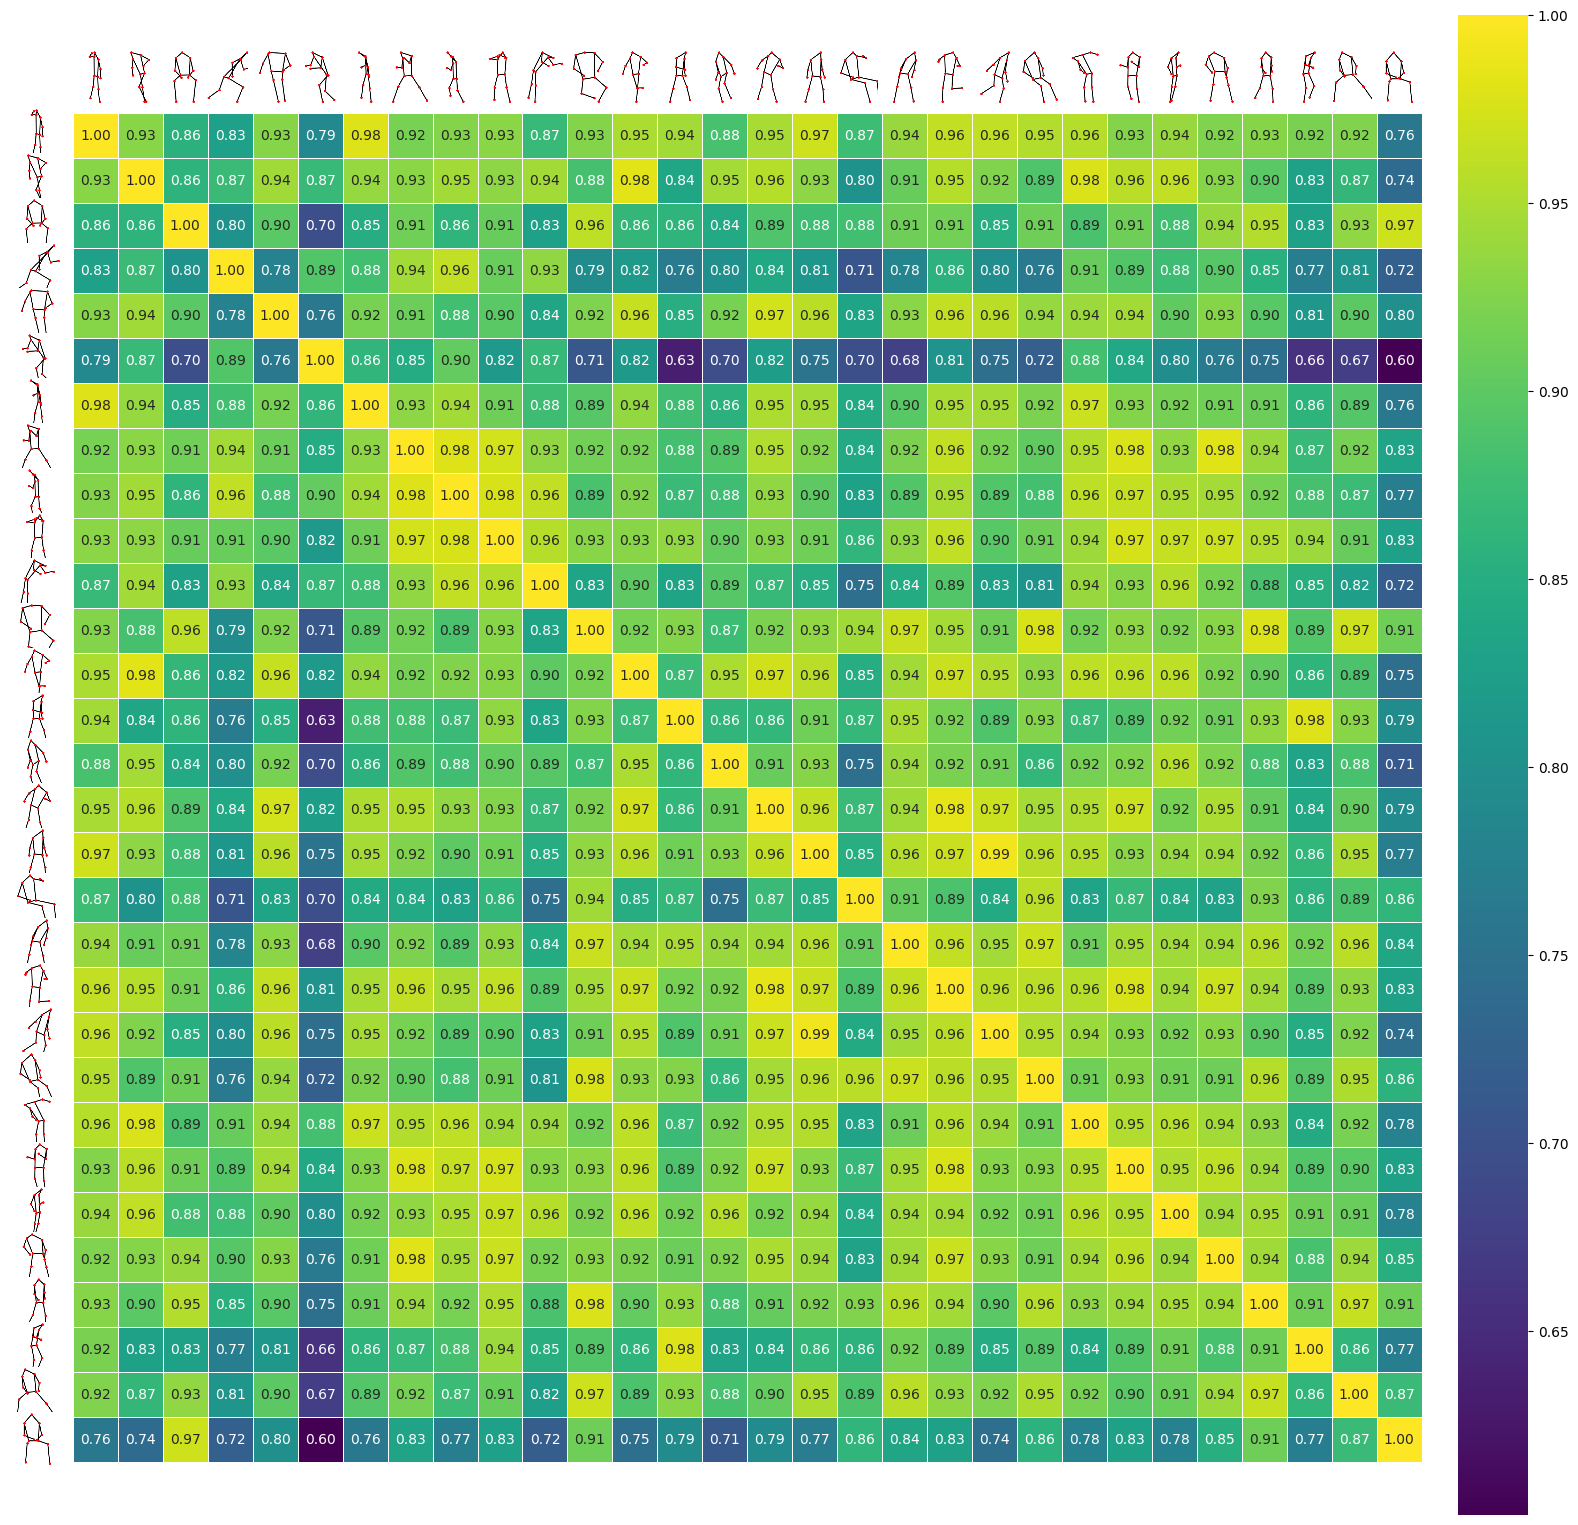

In [204]:
pose_images = []
for idx, pose in enumerate(poses_1):
    filename = f'pose_{idx}.png'
    plot_pose(pose, keypoint_names, connections, filename)
    pose_images.append(plt.imread(filename))

num_poses = len(poses_1)
similarity_matrix = np.zeros((num_poses, num_poses))

for i in range(num_poses):
    for j in range(num_poses):
        similarity_matrix[i, j] = compute_similarity(embeddings[i], embeddings[j])

plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = plt.subplot(gs[0])

sns.heatmap(
    similarity_matrix,
    cbar=True,         
    square=True,
    annot=True,         
    fmt=".2f",          
    annot_kws={"size": 10},  
    cmap="viridis",     
    linewidths=0.5,    
    linecolor='white',
    ax=ax,
    cbar_ax=plt.subplot(gs[1]) 
)

# Remove default labels
ax.set_xticks([])
ax.set_yticks([])

# Adjust axes limits to make room for images
ax.set_xlim(-1, num_poses)
ax.set_ylim(num_poses, -1)

# Function to add an image at a specific location
def add_image(ax, image, location, zoom):
    imagebox = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(
        imagebox,
        location,
        frameon=False,
        xycoords='data',
        pad=0
    )
    ax.add_artist(ab)

# Adjust zoom level for images
image_zoom = 0.25

# Add images as x-axis labels
for i in range(num_poses):
    add_image(ax, pose_images[i], (i + 0.5, -0.8), zoom=image_zoom)

# Add images as y-axis labels
for i in range(num_poses):
    add_image(ax, pose_images[i], (-0.8, i + 0.5), zoom=image_zoom)

# Hide axes spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust layout to make room for the colorbar and labels
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)

plt.show()


In [205]:
# Create a dataframe with the list of lists of poses
# Columns: 
# image/width,
# image/height,
# image/object/part/NOSE_TIP/center/x,
# image/object/part/NOSE_TIP/center/y,
# image/object/part/NOSE_TIP/score,
# image/object/part/LEFT_SHOULDER/center/x,
# image/object/part/LEFT_SHOULDER/center/y,
# image/object/part/LEFT_SHOULDER/score,
# image/object/part/RIGHT_SHOULDER/center/x,
# image/object/part/RIGHT_SHOULDER/center/y,
# ...


def create_dataframe(poses):
    data = []
    for pose in poses:
        row = []
        for kp in pose:
            row.extend([kp[0], kp[1], kp[2]])
        data.append(row)
    
    columns = []
    for kp in keypoint_names:
        kp = kp.replace('nose', 'nose_tip')
        columns.extend([f'image/object/part/{kp.upper()}/center/x', f'image/object/part/{kp.upper()}/center/y', f'image/object/part/{kp.upper()}/score'])
    
    return pd.DataFrame(data, columns=columns)

df = create_dataframe(poses)

In [206]:
# df['image/width'] = 1280
# df['image/height'] = 720
df.insert(0, 'image/width', 1280)
df.insert(1, 'image/height', 720)

In [207]:
# normalize x and y cords to be between 0 and 1
def normalize(df):
    for kp in keypoint_names:
        kp = kp.replace('nose', 'nose_tip')
        df[f'image/object/part/{kp.upper()}/center/x'] /= df['image/width']
        df[f'image/object/part/{kp.upper()}/center/y'] /= df['image/height']
    
    return df

In [208]:
df = normalize(df)

In [209]:
df

,image/width,image/height,image/object/part/NOSE_TIP/center/x,image/object/part/NOSE_TIP/center/y,image/object/part/NOSE_TIP/score,image/object/part/LEFT_SHOULDER/center/x,image/object/part/LEFT_SHOULDER/center/y,image/object/part/LEFT_SHOULDER/score,image/object/part/RIGHT_SHOULDER/center/x,image/object/part/RIGHT_SHOULDER/center/y,...,image/object/part/LEFT_KNEE/score,image/object/part/RIGHT_KNEE/center/x,image/object/part/RIGHT_KNEE/center/y,image/object/part/RIGHT_KNEE/score,image/object/part/LEFT_ANKLE/center/x,image/object/part/LEFT_ANKLE/center/y,image/object/part/LEFT_ANKLE/score,image/object/part/RIGHT_ANKLE/center/x,image/object/part/RIGHT_ANKLE/center/y,image/object/part/RIGHT_ANKLE/score
0,1280,720,0.624789,0.618306,0.93,0.633641,0.647903,1.00,0.623734,0.635236,...,0.86,0.621398,0.760667,0.82,0.636484,0.821458,0.71,0.615062,0.807569,0.63
1,1280,720,0.314969,0.364542,0.60,0.348125,0.379833,0.99,0.321797,0.403236,...,0.97,0.354625,0.577222,0.97,0.367266,0.664833,0.92,0.361906,0.665583,0.76
2,1280,720,0.458211,0.298972,0.69,0.466523,0.308528,0.90,0.451773,0.309069,...,0.73,0.450164,0.350417,0.74,0.469945,0.388375,0.74,0.452094,0.388083,0.60
3,1280,720,0.468031,0.678042,0.88,0.453727,0.708958,0.86,0.451883,0.704458,...,0.94,0.459187,0.820458,0.97,0.379070,0.863917,0.95,0.445437,0.880319,0.87
4,1280,720,0.380922,0.477431,0.57,0.454219,0.485917,0.98,0.375289,0.492069,...,0.70,0.399594,0.696764,0.91,0.451492,0.864153,0.68,0.422383,0.871431,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1280,720,0.490602,0.333431,1.00,0.537953,0.341639,0.91,0.427008,0.360153,...,0.89,0.427375,0.574417,0.88,0.524969,0.843361,0.92,0.429070,0.831875,0.92
96,1280,720,0.773977,0.294778,0.96,0.782195,0.358125,0.97,0.729055,0.358181,...,0.94,0.695094,0.627583,0.93,0.782125,0.761556,0.86,0.675531,0.757986,0.90
97,1280,720,0.269414,0.260375,1.00,0.279969,0.345444,0.96,0.223039,0.326514,...,0.89,0.313766,0.649819,0.95,0.233430,0.823542,0.89,0.348133,0.850500,0.86
98,1280,720,0.402398,0.201736,0.97,0.461273,0.298333,0.98,0.421594,0.282222,...,0.94,0.469430,0.712917,0.91,0.415164,0.884375,0.95,0.534672,0.824014,0.93


In [210]:
df.to_csv('/home/andre/google-research/poem/poses.csv', index=False)

In [ ]:
# python pr_vipe/infer.py --input_csv poses.csv --output_dir results/ --checkpoint_path checkpoints/checkpoint_Pr-VIPE_2M/model.ckpt-02013963

In [211]:
# read csv where the first row is data
df_poem = pd.read_csv('/home/andre/google-research/poem/results/unnormalized_embeddings.csv', header=None)

In [215]:
df_poem.shape

(100, 16)

In [212]:
embeddings_1 = df_poem.values

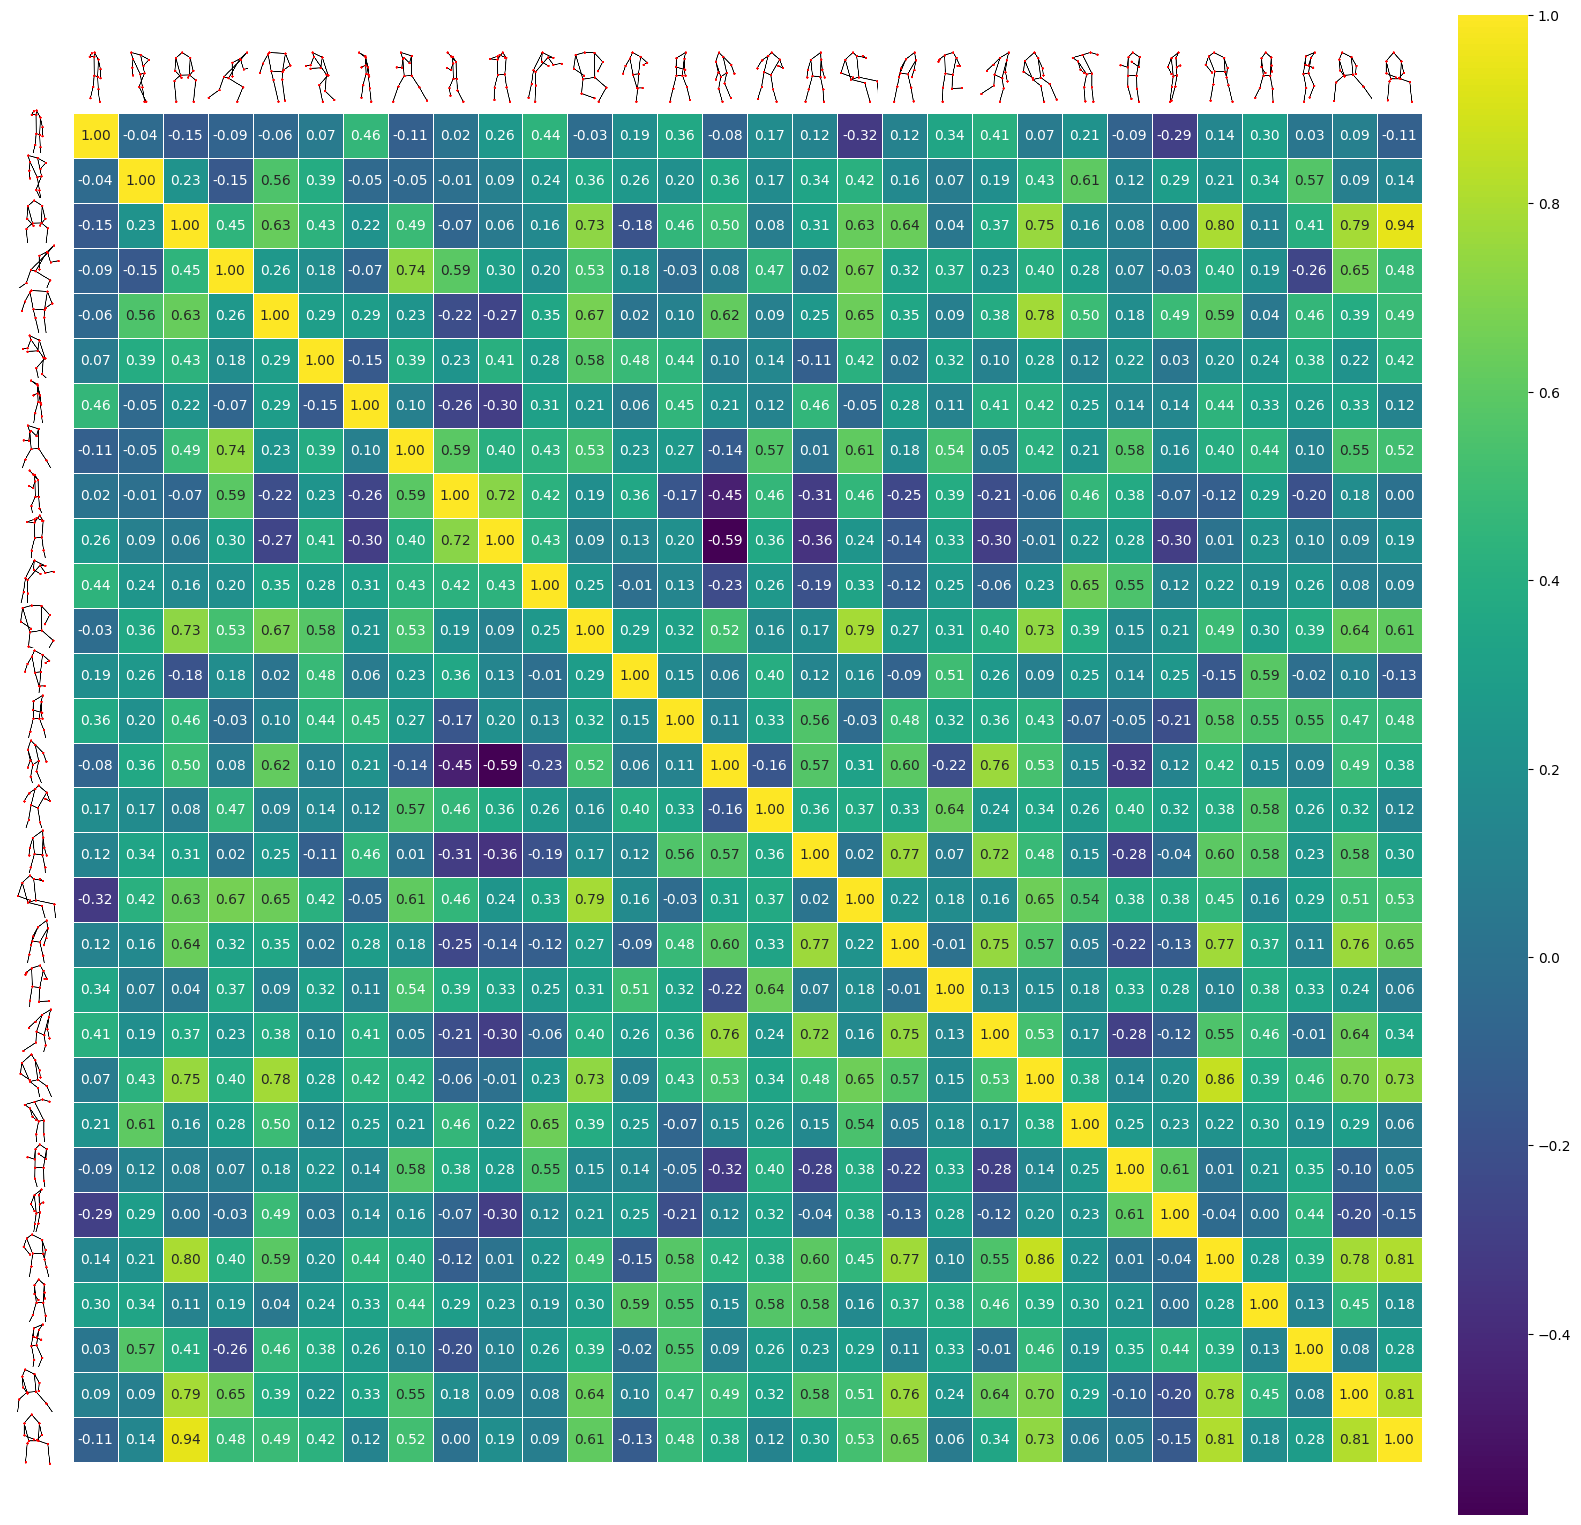

In [214]:
pose_images = []
for idx, pose in enumerate(poses_1):
    filename = f'pose_{idx}.png'
    plot_pose(pose, keypoint_names, connections, filename)
    pose_images.append(plt.imread(filename))

num_poses = len(poses_1)
similarity_matrix = np.zeros((num_poses, num_poses))

for i in range(num_poses):
    for j in range(num_poses):
        similarity_matrix[i, j] = compute_similarity(embeddings_1[i], embeddings_1[j])

plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = plt.subplot(gs[0])

sns.heatmap(
    similarity_matrix,
    cbar=True,         
    square=True,
    annot=True,         
    fmt=".2f",          
    annot_kws={"size": 10},  
    cmap="viridis",     
    linewidths=0.5,    
    linecolor='white',
    ax=ax,
    cbar_ax=plt.subplot(gs[1]) 
)

# Remove default labels
ax.set_xticks([])
ax.set_yticks([])

# Adjust axes limits to make room for images
ax.set_xlim(-1, num_poses)
ax.set_ylim(num_poses, -1)

# Function to add an image at a specific location
def add_image(ax, image, location, zoom):
    imagebox = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(
        imagebox,
        location,
        frameon=False,
        xycoords='data',
        pad=0
    )
    ax.add_artist(ab)

# Adjust zoom level for images
image_zoom = 0.25

# Add images as x-axis labels
for i in range(num_poses):
    add_image(ax, pose_images[i], (i + 0.5, -0.8), zoom=image_zoom)

# Add images as y-axis labels
for i in range(num_poses):
    add_image(ax, pose_images[i], (-0.8, i + 0.5), zoom=image_zoom)

# Hide axes spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust layout to make room for the colorbar and labels
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)

plt.show()


In [ ]:
len(poses)

100